# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


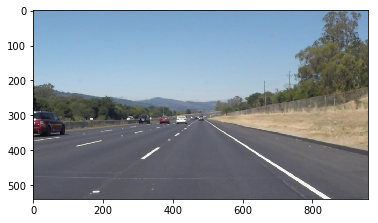

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# Tools available:
#     color selection, 
#     region of interest selection, 
#     grayscaling, 
#     Gaussian smoothing, 
#     Canny Edge Detection and 
#     Hough Tranform line detection
# Other techniques that can be explored
# 
#     cv2.inRange() for color selection
#     cv2.fillPoly() for regions selection
#     cv2.line() to draw lines on an image given endpoints
#     cv2.addWeighted() to coadd / overlay two images cv2.cvtColor() to grayscale or change color cv2.imwrite() to output images to file
#     cv2.bitwise_and() to apply a mask to an image
#
# Objective:
#     Create a pipeline that does these things
#         Detect the line segments in the image 
#         Average/extrapolate them 
#         Draw them onto the image for display
# Proposed Pipeline
#     1.) Grayscale image
#     2.) Capture region of interest
#     3.) Detect edges using Canny Edge Detection
#     4.) Detect lines using Hough Transform line detection
#     5.) Extrapolate lines
#     6.) Draw extrapolated lines to display


This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


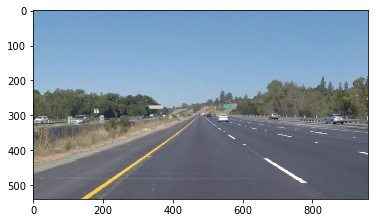

In [82]:
#reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  
# if you wanted to show a single color channel image called 'gray', 
# for example, call as plt.imshow(gray, cmap='gray')

In [111]:
def get_interpolated_lines(twolines, imshape, pos_slope, neg_slope, two_midpoints, max_y, min_y):
    interpolatedlines=np.ndarray(shape=(4,1,4), dtype=int)
    slopes=[pos_slope,neg_slope]
    #slopes=[]
#     for line in twolines:
#         for x1,y1,x2,y2 in line:
#             slope=float(y2-y1)/(x2-x1)
#             slopes.append(slope)
    #print(slopes)
    for ipt in range(2):
        points = two_midpoints[ipt]
        for x,y in points:
            x1=x
            y1=y
            y2=max_y
            x2=int(x1+((y2-y1)/slopes[ipt]))
        interpolatedlines[ipt]=(x1,y1,x2,y2)
    for ipt in range(2):
        points = two_midpoints[ipt]
        for x,y in points:
            x1=x
            y1=y
            y2=min_y
            x2=int(x1+((y2-y1)/slopes[ipt]))
        interpolatedlines[ipt+2]=(x1,y1,x2,y2)
    
    return interpolatedlines

[[713 452]] [[303 421]]
(540, 960, 3)
-0.72115 [(183, 521, 287, 446)]
-0.68116 [(311, 421, 380, 374)]
-0.67708 [(138, 539, 330, 409)]
-0.73171 [(284, 449, 325, 419)]
-0.75 [(341, 408, 417, 351)]
-0.78947 [(417, 352, 455, 322)]
-0.72857 [(375, 377, 445, 326)]
-0.92308 [(443, 327, 469, 303)]
-0.71429 [(158, 538, 207, 503)]
-0.67742 [(264, 453, 295, 432)]
0.53846 [[661 424 765 480]]
-0.71299 [[138 539 469 303]]
0.62857 [[713 452 853 540]]
-0.73913 [[303 421 142 540]]
0.63136 [[713 452 477 303]]
-0.74684 [[303 421 461 303]]


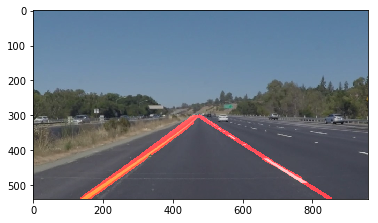

In [112]:
img=grayscale(image)
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
img = gaussian_blur(img, kernel_size)

imshape = img.shape
vertices = np.array([[(0,imshape[0]),(imshape[1]*7/16, imshape[0]*9/16), (imshape[1]*9/16, imshape[0]*9/16), (imshape[1],imshape[0])]], dtype=np.int32)
#img=region_of_interest(img, vertices)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = canny(img, low_threshold, high_threshold)

#plt.imshow(img)


# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
#vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
#vertices = np.array([[(0,imshape[0]),(imshape[1]/2, imshape[0]/2), (imshape[1]/2, imshape[0]/2), (imshape[1],imshape[0])]], dtype=np.int32)
vertices = np.array([[(0,imshape[0]),(imshape[1]*7/16, imshape[0]*9/16), (imshape[1]*9/16, imshape[0]*9/16), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 25 #minimum number of pixels making up a line
max_line_gap = 1    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

#interpolate ines based on their slopes
slopes={}
for line in lines:
    for x1,y1,x2,y2 in line:
        slope = round(float(y2-y1)/(x2-x1),5)
        if slope in slopes.keys():
            slopes[slope].append((x1,y1,x2,y2))
        else:
            slopes[slope]=[]
            slopes[slope].append((x1,y1,x2,y2))

newlines=np.ndarray(shape=(len(slopes.keys()),1,4), dtype=int)
for idx in range(len(slopes.keys())):
    all_keys=list(slopes.keys())
    slope = all_keys[idx]
    #print(slope, slopes[slope])
    if len(slopes[slope])==1:
        newlines[idx]=slopes[slope]
    else:
        x1,y1,x2,y2=slopes[slope][0]
        for jdx in range(1,len(slopes[slope])):
            x1_new,y1_new,x2_new,y2_new=slopes[slope][jdx]
            #if slope is positive, pick max x2 and max y2, min x1, min y1
            #print(x1_new,y1_new,x2_new,y2_new)
            if slope>0:
                x1=min(x1,x1_new)
                y1=min(y1,y1_new)
                x2=max(x2,x2_new)
                y2=max(y2,y2_new)
            else:
                x1=min(x1,x1_new)
                y1=max(y1,y1_new)
                x2=max(x2,x2_new)
                y2=min(y2,y2_new)
        newlines[idx]=(x1,y1,x2,y2)
    #print(newlines)

twolines=np.ndarray(shape=(2,1,4), dtype=int)
slopes_dict={'pos':[],'neg':[]}
for idx in range(len(slopes.keys())):
    all_keys=list(slopes.keys())
    slope = all_keys[idx]
    if slope>0:
        slopes_dict['pos'].append(slopes[slope])
    else:
        slopes_dict['neg'].append(slopes[slope])
#print(slopes_dict)
x1,y1,x2,y2=[imshape[1], imshape[0], 0, 0]
pos_slope=0
pos_count=0
for line in slopes_dict['pos']:
    for x1_new,y1_new,x2_new,y2_new in line:
        pos_count+=1
        pos_slope+=float(y2_new-y1_new)/(x2_new-x1_new)
        x1=min(x1,x1_new)
        y1=min(y1,y1_new)
        x2=max(x2,x2_new)
        y2=max(y2,y2_new)
    twolines[0]=(x1,y1,x2,y2)
pos_slope/=pos_count

x1,y1,x2,y2=[imshape[1], 0, 0, imshape[0]]
neg_slope=0
neg_count=0
for line in slopes_dict['neg']:
    for x1_new,y1_new,x2_new,y2_new in line:
        neg_count+=1
        neg_slope+=float(y2_new-y1_new)/(x2_new-x1_new)
        x1=min(x1,x1_new)
        y1=max(y1,y1_new)
        x2=max(x2,x2_new)
        y2=min(y2,y2_new)
    twolines[1]=(x1,y1,x2,y2)
neg_slope/=neg_count

#extrapolate slopes to get line with max y
two_midpoints=np.ndarray(shape=(2,1,2), dtype=int)
for idx in range(2):
    line = twolines[idx]
    for x1,y1,x2,y2 in line:
        x_mid=int((x1+x2)/2)
        y_mid=int((y1+y2)/2)
        #print(x1,y1,x2,y2,x_mid,y_mid)
        two_midpoints[idx]=(x_mid,y_mid)

print(two_midpoints[0],two_midpoints[1])
interpolatedlines=get_interpolated_lines(twolines, imshape, pos_slope, neg_slope, two_midpoints, imshape[0], imshape[0]*9/16)
print(imshape)
#print(type(lines),type(lines[0]),lines[0],lines.shape)
#print(type(newlines),type(newlines[0]),newlines[0],newlines.shape)
#print(type(twolines),type(twolines[0]),twolines[0],twolines.shape)
# Iterate over the output "lines" and draw lines on a blank image
# for line in lines:
#     for x1,y1,x2,y2 in line:
#         #print(x1,x2,y1,y2)
#         print(round(float(y2-y1)/(x2-x1),5),line)
#         cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
for line in slopes_dict['neg']:
    for x1,y1,x2,y2 in line:
        #print(x1,x2,y1,y2)
        print(round(float(y2-y1)/(x2-x1),5),line)
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
# for line in newlines:
#     for x1,y1,x2,y2 in line:
#         #print(x1,x2,y1,y2)
#         print(round(float(y2-y1)/(x2-x1),5),line)
#         cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
for line in twolines:
    for x1,y1,x2,y2 in line:
        #print(x1,x2,y1,y2)
        print(round(float(y2-y1)/(x2-x1),5),line)
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
for line in interpolatedlines:
    for x1,y1,x2,y2 in line:
        #print(x1,x2,y1,y2)
        print(round(float(y2-y1)/(x2-x1),5),line)
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 
#plt.imshow(color_edges)
# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
#plt.imshow(lines_edges)
final_image = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
plt.imshow(final_image)

In [56]:
image.shape

(540, 960, 3)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [92]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [572]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    img=grayscale(image)
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    img = gaussian_blur(img, kernel_size)

    imshape = img.shape
    #vertices = np.array([[(0,imshape[0]),(imshape[1]*7/16, imshape[0]*9/16), (imshape[1]*9/16, imshape[0]*9/16), (imshape[1],imshape[0])]], dtype=np.int32)
    #img=region_of_interest(img, vertices)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(img, low_threshold, high_threshold)

    #plt.imshow(img)


    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    #vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(0,imshape[0]),(imshape[1]/2, imshape[0]/2), (imshape[1]/2, imshape[0]/2), (imshape[1],imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(0,imshape[0]),(imshape[1]*7/16, imshape[0]*9/16), (imshape[1]*9/16, imshape[0]*9/16), (imshape[1],imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(0,imshape[0]),(imshape[1]*3/8, imshape[0]*5/8), (imshape[1]*5/8, imshape[0]*5/8), (imshape[1],imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(0,imshape[0]),(imshape[1]*4/10, imshape[0]*6/10), (imshape[1]*6/10, imshape[0]*6/10), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(imshape[1]*1/10,imshape[0]),(imshape[1]*4/10, imshape[0]*6/10), (imshape[1]*6/10, imshape[0]*6/10), (imshape[1]*9/10,imshape[0])]], dtype=np.int32)
    max_y = imshape[0]
    min_y = imshape[0]*6/10#imshape[0]*5/8#imshape[0]*9/16
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    #filter lines based on slope
    #remove close to horizontal or vertical lines
    min_slope=0.4
    max_slope=0.8
    lines = filter_lines_based_on_slope(lines, min_slope, max_slope)
    
    interpolatedlines = connect_broken_lines(lines)
    
    #interpolate lines based on their slopes
    slopes={}
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = round(float(y2-y1)/(x2-x1),5)
            if slope in slopes.keys():
                slopes[slope].append((x1,y1,x2,y2))
            else:
                slopes[slope]=[]
                slopes[slope].append((x1,y1,x2,y2))

    newlines=np.ndarray(shape=(len(slopes.keys()),1,4), dtype=int)
    for idx in range(len(slopes.keys())):
        all_keys=list(slopes.keys())
        slope = all_keys[idx]
        #print(slope, slopes[slope])
        if len(slopes[slope])==1:
            newlines[idx]=slopes[slope]
        else:
            x1,y1,x2,y2=slopes[slope][0]
            for jdx in range(1,len(slopes[slope])):
                x1_new,y1_new,x2_new,y2_new=slopes[slope][jdx]
                #if slope is positive, pick max x2 and max y2, min x1, min y1
                #print(x1_new,y1_new,x2_new,y2_new)
                if slope>0:
                    x1=min(x1,x1_new)
                    y1=min(y1,y1_new)
                    x2=max(x2,x2_new)
                    y2=max(y2,y2_new)
                else:
                    x1=min(x1,x1_new)
                    y1=max(y1,y1_new)
                    x2=max(x2,x2_new)
                    y2=min(y2,y2_new)
            newlines[idx]=(x1,y1,x2,y2)
        #print(newlines)

#     twolines=np.ndarray(shape=(2,1,4), dtype=int)
#     slopes_dict={'pos':[],'neg':[]}
#     for idx in range(len(slopes.keys())):
#         all_keys=list(slopes.keys())
#         slope = all_keys[idx]
#         if slope>0:
#             slopes_dict['pos'].append(slopes[slope])
#         else:
#             slopes_dict['neg'].append(slopes[slope])
#     #print(slopes_dict)
#     x1,y1,x2,y2=[imshape[1], imshape[0], 0, 0]
#     pos_slope=0
#     pos_count=0
#     for line in slopes_dict['pos']:
#         for x1_new,y1_new,x2_new,y2_new in line:
#             pos_count+=1
#             pos_slope+=float(y2_new-y1_new)/(x2_new-x1_new)
#             x1=min(x1,x1_new)
#             y1=min(y1,y1_new)
#             x2=max(x2,x2_new)
#             y2=max(y2,y2_new)
#         twolines[0]=(x1,y1,x2,y2)
#     pos_slope/=pos_count

#     x1,y1,x2,y2=[imshape[1], 0, 0, imshape[0]]
#     neg_slope=0
#     neg_count=0
#     for line in slopes_dict['neg']:
#         for x1_new,y1_new,x2_new,y2_new in line:
#             neg_count+=1
#             neg_slope+=float(y2_new-y1_new)/(x2_new-x1_new)
#             x1=min(x1,x1_new)
#             y1=max(y1,y1_new)
#             x2=max(x2,x2_new)
#             y2=min(y2,y2_new)
#         twolines[1]=(x1,y1,x2,y2)
#     #plt.imshow(image)
#     neg_slope/=neg_count

#     #extrapolate slopes to get line with max y
#     two_midpoints=np.ndarray(shape=(2,1,2), dtype=int)
#     for idx in range(2):
#         line = twolines[idx]
#         for x1,y1,x2,y2 in line:
#             x_mid=int((x1+x2)/2)
#             y_mid=int((y1+y2)/2)
#             #print(x1,y1,x2,y2,x_mid,y_mid)
#             two_midpoints[idx]=(x_mid,y_mid)

    #print(two_midpoints[0],two_midpoints[1])
    #interpolatedlines=get_interpolated_lines(twolines, imshape, pos_slope, neg_slope, two_midpoints, max_y, min_y)
    #print(imshape)
    #print(type(lines),type(lines[0]),lines[0],lines.shape)
    #print(type(newlines),type(newlines[0]),newlines[0],newlines.shape)
    #print(type(twolines),type(twolines[0]),twolines[0],twolines.shape)
    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            #print(x1,x2,y1,y2)
            #slope=round(float(y2-y1)/(x2-x1),3)
            #if abs(slope)> 0.4 and abs(slope) <0.8:
            #    print(round(float(y2-y1)/(x2-x1),3),line)
            cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),5)
#     for line in slopes_dict['neg']:
#         for x1,y1,x2,y2 in line:
#             #print(x1,x2,y1,y2)
#             #print(round(float(y2-y1)/(x2-x1),5),line)
#             cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
#     for line in newlines:
#         for x1,y1,x2,y2 in line:
#             #print(x1,x2,y1,y2)
#             slope=round(float(y2-y1)/(x2-x1),3)
#             if abs(slope)> 0.4 and abs(slope) <0.8:
#                 #print(round(float(y2-y1)/(x2-x1),5),line)
#                 cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
#     for line in twolines:
#         for x1,y1,x2,y2 in line:
#             #print(x1,x2,y1,y2)
#             #print(round(float(y2-y1)/(x2-x1),5),line)
#             cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    for line in interpolatedlines:
        for x1,y1,x2,y2 in line:
            #print(x1,x2,y1,y2)
            #print(round(float(y2-y1)/(x2-x1),5),line)
            cv2.line(line_image,(x1,y1),(x2,y2),(0,0,225),5)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    #plt.imshow(color_edges)
    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    #plt.imshow(lines_edges)
    final_image = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    #plt.imshow(final_image)
    return final_image

In [563]:
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg']

pos: [(496, 325, 514, 335), (548, 356, 563, 360), (606, 393, 658, 417)]
neg: [(154, 538, 439, 341)]
pos_interpolated: [[514 335 548 356]]
pos_interpolated: [[563 360 606 393]]


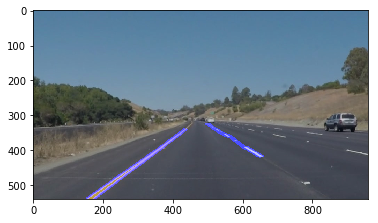

In [564]:
my_img = mpimg.imread('test_images/solidYellowCurve.jpg')
plt.imshow(process_image(my_img))

In [561]:
def connect_broken_lines(lines):
    my_lines=np.copy(lines)
    
    #rlines=my_lines[my_lines[:,0].argsort()]
    rlines=my_lines[my_lines[:,0][:,0].argsort()]
    
    #print(rlines)
    #find complete segments
    all_segments={'pos':[],'neg':[]}

    for line in rlines:
        for x1,y1,x2,y2 in line:
            slope = round(float(y2-y1)/(x2-x1),3)
            #print(slope,line)
            if slope>0:
                #print(slope,line)
                if len(all_segments['pos'])==0:
                    all_segments['pos'].append((x1,y1,x2,y2))
                else:
                    pos_segments=all_segments['pos']
                    pt_processed=False
                    for segment_num in range(len(pos_segments)):
                        segment = pos_segments[segment_num]
                        #print(segment)
                        sx1=segment[0];sy1=segment[1];sx2=segment[2];sy2=segment[3];
                        #print(sx1,sy1,sx2,sy2)
                        if x1>sx1 and x1<sx2:
                            #new point is in the middle of segment
                            if x2>sx2:
                                #sx2=x2
                                #sy2=y2
                                all_segments['pos'][segment_num]=(sx1,sy1,x2,y2)
                            pt_processed=True
                            break
                        elif x1>sx2:
                            #add new segment
                            pt_processed=False
                    if pt_processed==False:
                        all_segments['pos'].append((x1,y1,x2,y2))
            else:
                if len(all_segments['neg'])==0:
                    all_segments['neg'].append((x1,y1,x2,y2))
                else:
                    neg_segments=all_segments['neg']
                    pt_processed=False
                    for segment_num in range(len(neg_segments)):
                        segment = neg_segments[segment_num]
                        #print(segment)
                        sx1=segment[0];sy1=segment[1];sx2=segment[2];sy2=segment[3];
                        #print(sx1,sy1,sx2,sy2)
                        if x1>sx1 and x1<sx2:
                            #new point is in the middle of segment
                            if x2>sx2:
                                #sx2=x2
                                #sy2=y2
                                all_segments['neg'][segment_num]=(sx1,sy1,x2,y2)
                            pt_processed=True
                            break
                        elif x1>sx2:
                            #add new segment
                            pt_processed=False
                    if pt_processed==False:
                        all_segments['neg'].append((x1,y1,x2,y2))
                
    print('pos:', all_segments['pos'])
    print('neg:', all_segments['neg'])
    
    num_of_broken_segments_pos=len(all_segments['pos'])-1
    num_of_broken_segments_neg=len(all_segments['neg'])-1
    #create interpolated_segments
    interpolated = np.ndarray(shape=(num_of_broken_segments_pos + num_of_broken_segments_neg,1,4), dtype=int)
    pos_interpolated = np.ndarray(shape=(num_of_broken_segments_pos,1,4), dtype=int)
    
    pos_segments=all_segments['pos']
    for idx_pos in range(len(pos_segments)):
        segment=pos_segments[idx_pos]
        #print(idx_pos,segment)
        if idx_pos==0:
            startx=segment[2];starty=segment[3]
            continue
        endx=segment[0];endy=segment[1]
        pos_interpolated[idx_pos-1]=(startx,starty,endx,endy)
        interpolated[idx_pos-1]=(startx,starty,endx,endy)
        startx=segment[2];starty=segment[3]
    #print(pos_interpolated)
    
    for interpolated_line in pos_interpolated:
        for x1,y1,x2,y2 in interpolated_line:
            print('pos_interpolated:',interpolated_line)
    #print(pos_interpolated)
    
    neg_interpolated = np.ndarray(shape=(num_of_broken_segments_neg,1,4), dtype=int)
    neg_segments=all_segments['neg']
    for idx_neg in range(len(neg_segments)):
        segment=neg_segments[idx_neg]
        #print(idx_neg,segment)
        if idx_neg==0:
            startx=segment[2];starty=segment[3]
            continue
        endx=segment[0];endy=segment[1]
        neg_interpolated[idx_neg-1]=(startx,starty,endx,endy)
        interpolated[num_of_broken_segments_pos+idx_neg-1]=(startx,starty,endx,endy)
        startx=segment[2];starty=segment[3]
    #print(neg_interpolated)
    
    for interpolated_line in neg_interpolated:
        for x1,y1,x2,y2 in interpolated_line:
            print('neg_interpolated:',interpolated_line)

    return interpolated

In [519]:
def filter_lines_based_on_slope(lines, min_slope, max_slope):
    #get number of lines meeting slope criterion
    num_of_lines = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #print(x1,x2,y1,y2)
            slope=round(float(y2-y1)/(x2-x1),3)
            if abs(slope)> min_slope and abs(slope) < max_slope:
                num_of_lines +=1
    #allocate space of filtered lines
    rlines = np.ndarray(shape=(num_of_lines,1,4), dtype=int)
    idx = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #print(x1,x2,y1,y2)
            slope=round(float(y2-y1)/(x2-x1),3)
            if abs(slope)> 0.4 and abs(slope) <0.8:
                #print(round(float(y2-y1)/(x2-x1),3),line)
                rlines[idx]=(x1,y1,x2,y2)
                idx +=1
    
    return rlines

pos: [(501, 324, 519, 330), (569, 364, 591, 373), (700, 447, 847, 536)]
neg: [(159, 538, 456, 325)]
pos_interpolated: [[519 330 569 364]]
pos_interpolated: [[591 373 700 447]]


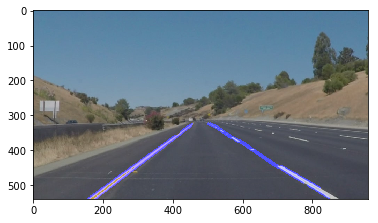

In [565]:
my_img = mpimg.imread('test_images/solidYellowCurve2.jpg')
plt.imshow(process_image(my_img))

pos: [(504, 325, 521, 332), (582, 370, 607, 381), (743, 467, 862, 538)]
neg: [(176, 539, 438, 344), (176, 538, 205, 516)]
pos_interpolated: [[521 332 582 370]]
pos_interpolated: [[607 381 743 467]]
neg_interpolated: [[438 344 176 538]]


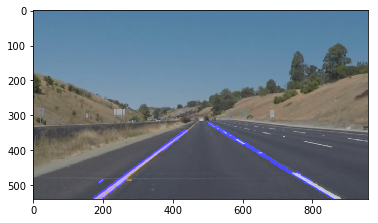

In [566]:
my_img = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
plt.imshow(process_image(my_img))

pos: [(558, 358, 576, 365), (661, 424, 767, 481)]
neg: [(138, 539, 453, 324)]
pos_interpolated: [[576 365 661 424]]


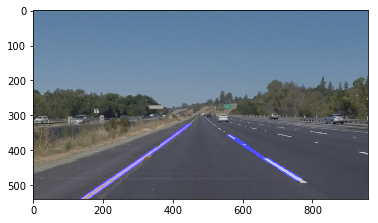

In [567]:
my_img = mpimg.imread('test_images/solidYellowLeft.jpg')
plt.imshow(process_image(my_img))

pos: [(507, 325, 815, 503)]
neg: [(287, 455, 345, 410), (405, 363, 417, 355), (451, 335, 466, 324)]
neg_interpolated: [[345 410 405 363]]
neg_interpolated: [[417 355 451 335]]


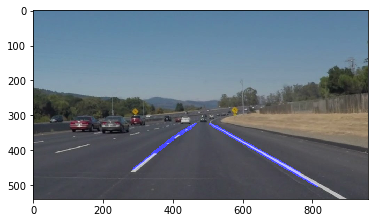

In [568]:
my_img = mpimg.imread('test_images/solidWhiteCurve.jpg')
plt.imshow(process_image(my_img))

pos: [(505, 324, 853, 538)]
neg: [(315, 420, 363, 394)]


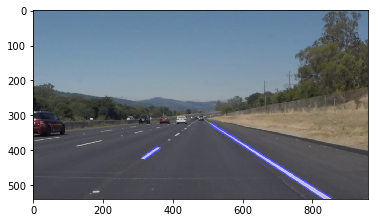

In [569]:
my_img = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(process_image(my_img))

Let's try the one with the solid white lane on the right first ...

In [573]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

pos: [(507, 324, 847, 539)]
neg: [(187, 512, 303, 438), (388, 367, 406, 359)]
neg_interpolated: [[303 438 388 367]]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  2%|▏         | 5/222 [00:00<00:04, 46.29it/s]

pos: [(507, 324, 847, 539)]
neg: [(187, 512, 303, 438), (388, 367, 406, 359)]
neg_interpolated: [[303 438 388 367]]
pos: [(507, 324, 846, 538)]
neg: [(150, 538, 289, 449), (383, 371, 403, 362)]
neg_interpolated: [[289 449 383 371]]
pos: [(507, 324, 846, 538)]
neg: [(150, 538, 261, 470), (376, 377, 387, 369), (376, 376, 395, 363)]
neg_interpolated: [[261 470 376 377]]
neg_interpolated: [[387 369 376 376]]
pos: [(507, 324, 847, 538)]
neg: [(148, 538, 225, 496), (369, 381, 394, 368), (369, 382, 387, 369)]
neg_interpolated: [[225 496 369 381]]
neg_interpolated: [[394 368 369 382]]
pos: [(507, 324, 848, 538)]
neg: [(360, 387, 389, 372)]
pos: [(509, 324, 848, 538)]
neg: [(351, 393, 384, 375)]
pos: [(509, 324, 848, 538)]
neg: [(339, 401, 377, 381), (339, 403, 352, 393)]
neg_interpolated: [[377 381 339 403]]
pos: [(510, 325, 850, 538)]
neg: [(326, 410, 370, 385)]
pos: [(509, 324, 848, 538)]
neg: [(310, 422, 361, 393), (406, 355, 419, 350)]
neg_interpolated: [[361 393 406 355]]


  4%|▍         | 9/222 [00:00<00:05, 41.13it/s]

pos: [(506, 324, 847, 527)]
neg: [(289, 439, 351, 402), (406, 361, 416, 354)]
neg_interpolated: [[351 402 406 361]]
pos: [(502, 324, 860, 538)]
neg: [(263, 459, 339, 412), (401, 366, 413, 358), (443, 332, 454, 324)]
neg_interpolated: [[339 412 401 366]]
neg_interpolated: [[413 358 443 332]]
pos: [(501, 324, 838, 528)]
neg: [(230, 482, 321, 425), (393, 368, 409, 361)]
neg_interpolated: [[321 425 393 368]]
pos: [(507, 327, 855, 538)]
neg: [(183, 514, 307, 434), (388, 370, 406, 362), (441, 334, 454, 324)]
neg_interpolated: [[307 434 388 370]]
neg_interpolated: [[406 362 441 334]]


  6%|▌         | 13/222 [00:00<00:05, 39.11it/s]

pos: [(506, 324, 856, 538)]
neg: [(145, 539, 156, 531), (145, 538, 285, 448), (381, 372, 402, 363)]
neg_interpolated: [[156 531 145 538]]
neg_interpolated: [[285 448 381 372]]
pos: [(509, 324, 854, 537)]
neg: [(146, 536, 258, 466), (375, 374, 398, 364)]
neg_interpolated: [[258 466 375 374]]
pos: [(510, 324, 859, 539)]
neg: [(138, 538, 221, 491), (368, 378, 394, 366)]
neg_interpolated: [[221 491 368 378]]
pos: [(517, 324, 860, 538), (517, 328, 558, 353)]
neg: [(136, 538, 149, 529), (156, 538, 169, 529), (360, 384, 389, 369), (360, 383, 374, 373)]
pos_interpolated: [[860 538 517 328]]

  8%|▊         | 17/222 [00:00<00:05, 37.29it/s]


neg_interpolated: [[149 529 156 538]]
neg_interpolated: [[169 529 360 384]]
neg_interpolated: [[389 369 360 383]]
pos: [(516, 324, 858, 538)]
neg: [(350, 391, 384, 373)]
pos: [(508, 324, 855, 538)]
neg: [(339, 400, 377, 380)]
pos: [(509, 325, 855, 538)]
neg: [(326, 411, 366, 389)]
pos: [(505, 324, 853, 538)]
neg: [(310, 423, 362, 394)]


 10%|▉         | 22/222 [00:00<00:05, 36.28it/s]

pos: [(504, 324, 854, 539)]
neg: [(290, 438, 352, 401), (402, 360, 413, 353)]
neg_interpolated: [[352 401 402 360]]
pos: [(505, 324, 853, 537)]
neg: [(264, 454, 341, 409), (399, 362, 409, 355)]
neg_interpolated: [[341 409 399 362]]


 11%|█▏        | 25/222 [00:00<00:06, 32.56it/s]

pos: [(507, 324, 854, 539)]
neg: [(232, 476, 327, 419), (393, 365, 410, 358)]
neg_interpolated: [[327 419 393 365]]
pos: [(507, 324, 855, 539)]
neg: [(186, 507, 310, 431), (390, 368, 407, 360), (441, 331, 451, 324)]
neg_interpolated: [[310 431 390 368]]
neg_interpolated: [[407 360 441 331]]
pos: [(507, 324, 854, 538)]
neg: [(146, 536, 289, 447), (384, 371, 404, 363)]
neg_interpolated: [[289 447 384 371]]
pos: [(507, 324, 855, 538)]
neg: [(142, 539, 261, 468), (377, 377, 399, 367), (377, 376, 388, 369)]
neg_interpolated: [[261 468 377 377]]
neg_interpolated: [[399 367 377 376]]


 13%|█▎        | 28/222 [00:00<00:06, 31.09it/s]

pos: [(508, 324, 856, 538)]
neg: [(142, 539, 225, 494), (370, 381, 395, 369)]
neg_interpolated: [[225 494 370 381]]
pos: [(508, 324, 856, 538)]
neg: [(149, 535, 160, 528), (362, 388, 390, 374)]
neg_interpolated: [[160 528 362 388]]


 15%|█▍        | 33/222 [00:00<00:05, 33.74it/s]

pos: [(508, 324, 857, 538)]
neg: [(352, 394, 385, 376)]
pos: [(510, 324, 857, 539)]
neg: [(341, 401, 379, 380)]
pos: [(510, 324, 858, 539)]
neg: [(328, 410, 371, 386), (328, 409, 364, 384)]
neg_interpolated: [[371 386 328 409]]
pos: [(510, 324, 857, 537)]
neg: [(311, 421, 357, 396)]
pos: [(508, 324, 858, 539)]
neg: [(292, 435, 347, 397), (406, 360, 417, 352)]
neg_interpolated: [[347 397 406 360]]
pos: [(507, 324, 856, 538)]
neg: [(267, 453, 342, 408), (399, 361, 414, 355)]
neg_interpolated: [[342 408 399 361]]
pos: [(509, 325, 855, 538)]
neg: [(235, 476, 328, 418), (394, 365, 412, 358)]
neg_interpolated: [[328 418 394 365]]


 17%|█▋        | 37/222 [00:01<00:05, 34.62it/s]

pos: [(506, 324, 538, 344), (539, 346, 855, 538)]
neg: [(191, 506, 312, 432), (390, 369, 408, 361)]
pos_interpolated: [[538 344 539 346]]
neg_interpolated: [[312 432 390 369]]
pos: [(506, 324, 854, 538)]
neg: [(146, 538, 287, 449), (385, 372, 405, 363)]


 19%|█▉        | 42/222 [00:01<00:04, 37.35it/s]

neg_interpolated: [[287 449 385 372]]
pos: [(508, 324, 855, 538)]
neg: [(145, 539, 264, 465), (379, 376, 401, 365)]
neg_interpolated: [[264 465 379 376]]
pos: [(510, 324, 855, 538)]
neg: [(143, 538, 224, 494), (371, 380, 396, 368)]
neg_interpolated: [[224 494 371 380]]
pos: [(509, 324, 855, 538)]
neg: [(142, 539, 163, 524), (164, 538, 180, 526), (363, 385, 391, 370)]
neg_interpolated: [[163 524 164 538]]
neg_interpolated: [[180 526 363 385]]
pos: [(511, 324, 854, 538)]
neg: [(354, 392, 385, 375)]
pos: [(511, 324, 854, 539)]
neg: [(343, 398, 379, 378)]
pos: [(513, 325, 852, 537)]
neg: [(329, 407, 372, 383)]
pos: [(514, 326, 853, 538)]
neg: [(313, 418, 364, 389), (407, 356, 417, 349)]
neg_interpolated: [[364 389 407 356]]
pos: [(510, 324, 855, 538)]
neg: [(295, 432, 354, 397), (401, 356, 413, 348)]
neg_interpolated: [[354 397 401 356]]


 23%|██▎       | 50/222 [00:01<00:05, 32.50it/s]

pos: [(511, 324, 855, 538)]
neg: [(275, 445, 342, 404), (396, 359, 408, 350)]
neg_interpolated: [[342 404 396 359]]
pos: [(512, 325, 853, 538)]
neg: [(240, 470, 329, 415), (392, 362, 409, 355)]
neg_interpolated: [[329 415 392 362]]
pos: [(509, 324, 853, 538)]
neg: [(198, 499, 313, 426), (387, 365, 405, 358)]
neg_interpolated: [[313 426 387 365]]
pos: [(514, 327, 853, 538)]
neg: [(140, 538, 292, 441), (381, 369, 401, 360)]
neg_interpolated: [[292 441 381 369]]
pos: [(512, 326, 853, 538)]
neg: [(139, 539, 259, 465), (139, 538, 149, 531), (378, 372, 397, 364), (378, 376, 396, 364)]
neg_interpolated: [[259 465 139 538]]
neg_interpolated: [[149 531 378 372]]
neg_interpolated: [[397 364 378 376]]
pos: [(514, 327, 853, 538), (514, 324, 585, 368)]
neg: [(137, 539, 232, 483), (366, 378, 390, 367)]
pos_interpolated: [[853 538 514 324]]
neg_interpolated: [[232 483 366 378]]


 26%|██▌       | 58/222 [00:01<00:04, 34.66it/s]

pos: [(508, 324, 853, 538)]
neg: [(135, 538, 185, 517), (358, 384, 387, 370)]
neg_interpolated: [[185 517 358 384]]
pos: [(507, 324, 853, 538)]
neg: [(348, 391, 380, 374)]
pos: [(507, 324, 852, 538)]
neg: [(337, 399, 374, 379), (337, 398, 358, 384), (434, 333, 447, 324)]
neg_interpolated: [[374 379 337 398]]
neg_interpolated: [[358 384 434 333]]
pos: [(506, 324, 852, 538)]
neg: [(322, 409, 366, 385)]
pos: [(504, 324, 852, 538)]
neg: [(170, 514, 180, 507), (306, 421, 357, 392), (402, 355, 412, 349)]
neg_interpolated: [[180 507 306 421]]
neg_interpolated: [[357 392 402 355]]
pos: [(503, 324, 850, 539)]
neg: [(286, 435, 347, 400), (399, 358, 414, 353)]
neg_interpolated: [[347 400 399 358]]
pos: [(509, 324, 849, 538), (509, 328, 574, 369)]
neg: [(260, 453, 335, 408), (395, 361, 410, 355)]
pos_interpolated: [[849 538 509 328]]
neg_interpolated: [[335 408 395 361]]
pos: [(505, 325, 848, 538)]
neg: [(226, 475, 321, 418), (390, 363, 407, 357)]
neg_interpolated: [[321 418 390 363]]


 28%|██▊       | 62/222 [00:01<00:05, 28.52it/s]

pos: [(503, 324, 831, 530), (831, 529, 845, 538)]
neg: [(181, 505, 303, 431), (385, 368, 404, 360)]
pos_interpolated: [[831 530 831 529]]
neg_interpolated: [[303 431 385 368]]
pos: [(505, 325, 844, 539)]
neg: [(132, 538, 280, 447), (379, 371, 400, 362)]
neg_interpolated: [[280 447 379 371]]
pos: [(507, 327, 844, 538)]
neg: [(132, 538, 252, 467), (373, 376, 396, 364), (437, 333, 447, 326)]
neg_interpolated: [[252 467 373 376]]
neg_interpolated: [[396 364 437 333]]
pos: [(508, 324, 843, 538), (508, 328, 523, 337)]
neg: [(134, 536, 148, 526), (149, 526, 215, 492), (367, 380, 391, 369)]
pos_interpolated: [[843 538 508 328]]
neg_interpolated: [[148 526 149 526]]
neg_interpolated: [[215 492 367 380]]


 31%|███       | 69/222 [00:02<00:05, 25.65it/s]

pos: [(507, 327, 842, 539)]
neg: [(151, 536, 163, 527), (357, 386, 385, 373), (441, 331, 451, 324)]
neg_interpolated: [[163 527 357 386]]
neg_interpolated: [[385 373 441 331]]
pos: [(503, 324, 843, 538)]
neg: [(347, 393, 380, 376), (347, 391, 374, 374)]
neg_interpolated: [[380 376 347 391]]
pos: [(505, 324, 845, 538)]
neg: [(336, 398, 372, 379), (432, 334, 446, 325)]
neg_interpolated: [[372 379 432 334]]
pos: [(506, 324, 846, 538)]
neg: [(322, 406, 365, 384), (405, 352, 415, 346)]
neg_interpolated: [[365 384 405 352]]
pos: [(505, 324, 846, 539)]
neg: [(306, 418, 357, 389), (402, 354, 412, 348)]
neg_interpolated: [[357 389 402 354]]
pos: [(506, 324, 844, 539)]
neg: [(286, 431, 347, 398), (397, 357, 410, 350)]
neg_interpolated: [[347 398 397 357]]


 32%|███▏      | 72/222 [00:02<00:06, 22.95it/s]

pos: [(508, 326, 844, 539)]
neg: [(262, 448, 335, 406), (394, 360, 410, 354)]
neg_interpolated: [[335 406 394 360]]
pos: [(511, 328, 843, 538), (511, 324, 577, 368)]
neg: [(230, 467, 322, 413), (389, 362, 406, 356)]
pos_interpolated: [[843 538 511 324]]
neg_interpolated: [[322 413 389 362]]
pos: [(508, 326, 843, 538)]
neg: [(187, 497, 304, 426), (384, 367, 403, 358)]
neg_interpolated: [[304 426 384 367]]
pos: [(505, 324, 842, 539)]
neg: [(138, 529, 283, 441), (378, 371, 399, 361)]
neg_interpolated: [[283 441 378 371]]


 35%|███▌      | 78/222 [00:02<00:06, 23.56it/s]

pos: [(506, 324, 841, 538)]
neg: [(123, 538, 248, 465), (371, 374, 394, 365), (371, 375, 391, 362)]
neg_interpolated: [[248 465 371 374]]
neg_interpolated: [[394 365 371 375]]
pos: [(506, 324, 841, 538)]
neg: [(120, 538, 220, 484), (363, 380, 390, 366)]
neg_interpolated: [[220 484 363 380]]
pos: [(506, 324, 840, 538)]
neg: [(119, 538, 172, 515), (355, 384, 384, 369)]
neg_interpolated: [[172 515 355 384]]
pos: [(506, 324, 838, 537)]
neg: [(345, 390, 378, 374)]
pos: [(506, 324, 836, 538)]
neg: [(333, 398, 371, 378)]
pos: [(512, 329, 835, 538)]
neg: [(319, 407, 364, 384), (403, 352, 413, 346)]
neg_interpolated: [[364 384 403 352]]


 38%|███▊      | 84/222 [00:02<00:05, 23.32it/s]

pos: [(507, 324, 835, 538)]
neg: [(302, 417, 355, 389), (399, 354, 409, 348)]
neg_interpolated: [[355 389 399 354]]
pos: [(506, 324, 834, 538)]
neg: [(282, 430, 344, 396), (396, 357, 410, 352)]
neg_interpolated: [[344 396 396 357]]
pos: [(505, 324, 833, 539)]
neg: [(257, 447, 333, 404), (391, 360, 407, 354), (391, 359, 402, 352)]
neg_interpolated: [[333 404 391 360]]
neg_interpolated: [[407 354 391 359]]
pos: [(507, 324, 825, 534)]
neg: [(226, 466, 319, 413), (387, 362, 404, 355)]
neg_interpolated: [[319 413 387 362]]
pos: [(507, 324, 832, 538)]
neg: [(182, 495, 302, 425), (382, 365, 400, 358), (382, 366, 395, 358)]
neg_interpolated: [[302 425 382 365]]
neg_interpolated: [[400 358 382 366]]


 39%|███▉      | 87/222 [00:02<00:05, 23.45it/s]

pos: [(506, 324, 832, 539)]
neg: [(122, 534, 281, 440), (376, 370, 395, 362)]
neg_interpolated: [[281 440 376 370]]
pos: [(507, 324, 832, 538)]
neg: [(122, 535, 255, 459), (369, 374, 393, 364), (437, 331, 447, 324)]
neg_interpolated: [[255 459 369 374]]
neg_interpolated: [[393 364 437 331]]
pos: [(506, 324, 831, 538)]
neg: [(118, 538, 219, 483), (362, 379, 388, 368), (435, 332, 447, 324)]
neg_interpolated: [[219 483 362 379]]
neg_interpolated: [[388 368 435 332]]
pos: [(507, 324, 831, 538)]
neg: [(118, 539, 171, 516), (354, 385, 383, 371)]
neg_interpolated: [[171 516 354 385]]
pos: [(511, 326, 830, 538)]
neg: [(345, 391, 378, 375)]


 42%|████▏     | 94/222 [00:03<00:04, 25.80it/s]

pos: [(507, 324, 829, 539)]
neg: [(334, 400, 372, 380)]
pos: [(507, 324, 830, 538)]
neg: [(321, 409, 365, 386), (409, 356, 419, 350)]
neg_interpolated: [[365 386 409 356]]
pos: [(508, 324, 829, 538)]
neg: [(305, 419, 356, 392), (403, 357, 416, 352)]
neg_interpolated: [[356 392 403 357]]
pos: [(508, 324, 821, 534)]
neg: [(286, 431, 347, 398), (399, 358, 411, 351)]
neg_interpolated: [[347 398 399 358]]
pos: [(509, 324, 830, 538)]
neg: [(264, 445, 335, 405), (395, 360, 411, 354)]
neg_interpolated: [[335 405 395 360]]
pos: [(518, 328, 831, 538)]
neg: [(234, 464, 322, 414), (391, 362, 409, 355)]
neg_interpolated: [[322 414 391 362]]
pos: [(529, 331, 832, 538), (529, 336, 542, 346), (529, 335, 593, 383)]
neg: [(190, 492, 305, 425), (386, 366, 406, 357)]
pos_interpolated: [[832 538 529 336]]

 44%|████▎     | 97/222 [00:03<00:05, 23.57it/s]


pos_interpolated: [[542 346 529 335]]
neg_interpolated: [[305 425 386 366]]
pos: [(513, 324, 831, 539)]
neg: [(132, 529, 285, 438), (381, 369, 402, 360)]
neg_interpolated: [[285 438 381 369]]
pos: [(513, 324, 831, 539)]
neg: [(117, 538, 259, 456), (375, 373, 395, 365)]
neg_interpolated: [[259 456 375 373]]
pos: [(513, 324, 579, 365), (579, 366, 833, 539)]
neg: [(116, 538, 224, 479), (368, 377, 394, 365)]
pos_interpolated: [[579 365 579 366]]
neg_interpolated: [[224 479 368 377]]
pos: [(512, 324, 832, 538)]
neg: [(117, 538, 179, 509), (362, 381, 389, 369)]
neg_interpolated: [[179 509 362 381]]


 47%|████▋     | 104/222 [00:03<00:05, 20.69it/s]

pos: [(512, 324, 832, 538)]
neg: [(350, 391, 384, 374)]
pos: [(516, 324, 832, 538), (516, 328, 543, 347)]
neg: [(339, 398, 377, 380), (339, 400, 354, 390)]
pos_interpolated: [[832 538 516 328]]
neg_interpolated: [[377 380 339 400]]
pos: [(508, 324, 833, 538)]
neg: [(326, 409, 370, 386)]
pos: [(511, 324, 835, 538)]
neg: [(311, 418, 363, 389), (409, 357, 419, 350)]
neg_interpolated: [[363 389 409 357]]
pos: [(512, 324, 836, 539)]
neg: [(292, 430, 353, 397), (403, 356, 417, 351)]
neg_interpolated: [[353 397 403 356]]


 48%|████▊     | 107/222 [00:03<00:05, 21.10it/s]

pos: [(512, 324, 838, 538)]
neg: [(268, 446, 341, 405), (398, 358, 413, 352)]
neg_interpolated: [[341 405 398 358]]
pos: [(512, 324, 825, 530), (825, 529, 839, 538)]
neg: [(238, 466, 328, 414), (394, 362, 411, 355)]
pos_interpolated: [[825 530 825 529]]
neg_interpolated: [[328 414 394 362]]
pos: [(511, 324, 838, 538)]
neg: [(198, 493, 312, 425), (389, 365, 408, 357)]
neg_interpolated: [[312 425 389 365]]
pos: [(510, 324, 838, 539)]
neg: [(142, 530, 292, 440), (384, 368, 404, 360), (443, 331, 453, 324)]
neg_interpolated: [[292 440 384 368]]
neg_interpolated: [[404 360 443 331]]


 53%|█████▎    | 117/222 [00:04<00:04, 25.62it/s]

pos: [(514, 326, 837, 538)]
neg: [(132, 538, 265, 459), (377, 374, 399, 363)]
neg_interpolated: [[265 459 377 374]]
pos: [(509, 324, 834, 536)]
neg: [(133, 538, 234, 482), (370, 378, 395, 367), (370, 379, 383, 370)]
neg_interpolated: [[234 482 370 378]]
neg_interpolated: [[395 367 370 379]]
pos: [(515, 324, 840, 539)]
neg: [(133, 538, 177, 510), (362, 383, 390, 369)]
neg_interpolated: [[177 510 362 383]]
pos: [(511, 324, 841, 538)]
neg: [(353, 390, 384, 374), (353, 389, 382, 371)]
neg_interpolated: [[384 374 353 389]]
pos: [(512, 324, 844, 538)]
neg: [(343, 395, 378, 377)]
pos: [(511, 324, 844, 538)]
neg: [(330, 404, 371, 381)]
pos: [(511, 324, 846, 538)]
neg: [(314, 414, 359, 385)]
pos: [(512, 324, 846, 538)]
neg: [(296, 426, 354, 393), (404, 356, 418, 351)]
neg_interpolated: [[354 393 404 356]]
pos: [(510, 324, 848, 538)]
neg: [(273, 441, 343, 401), (400, 359, 416, 352), (400, 358, 411, 351)]
neg_interpolated: [[343 401 400 359]]
neg_interpolated: [[416 352 400 358]]
pos: [(510, 324,

 55%|█████▌    | 123/222 [00:04<00:05, 19.76it/s]

pos: [(508, 324, 850, 538)]
neg: [(205, 489, 314, 424), (391, 366, 410, 359), (391, 367, 401, 360)]
neg_interpolated: [[314 424 391 366]]
neg_interpolated: [[410 359 391 367]]
pos: [(507, 324, 851, 538)]
neg: [(152, 525, 293, 438), (386, 371, 406, 362)]
neg_interpolated: [[293 438 386 371]]
pos: [(510, 325, 852, 538)]
neg: [(132, 538, 270, 455), (380, 374, 402, 364), (442, 333, 455, 324)]
neg_interpolated: [[270 455 380 374]]
neg_interpolated: [[402 364 442 333]]
pos: [(509, 325, 852, 538)]
neg: [(131, 538, 238, 477), (373, 379, 395, 369)]
neg_interpolated: [[238 477 373 379]]
pos: [(509, 324, 854, 538)]
neg: [(130, 538, 196, 506), (366, 384, 393, 370), (366, 383, 389, 368)]
neg_interpolated: [[196 506 366 384]]
neg_interpolated: [[393 370 366 383]]
pos: [(509, 324, 856, 538)]
neg: [(357, 390, 388, 374)]


 59%|█████▉    | 131/222 [00:04<00:03, 25.14it/s]

pos: [(510, 324, 857, 538)]
neg: [(346, 397, 383, 379)]
pos: [(510, 324, 858, 538)]
neg: [(335, 406, 375, 384)]
pos: [(510, 324, 859, 538)]
neg: [(191, 503, 201, 497), (320, 417, 369, 388), (320, 416, 337, 405), (410, 356, 420, 349)]
neg_interpolated: [[201 497 320 417]]
neg_interpolated: [[369 388 320 416]]
neg_interpolated: [[337 405 410 356]]
pos: [(509, 324, 859, 538)]
neg: [(303, 429, 359, 397), (406, 359, 420, 353), (406, 358, 417, 351)]
neg_interpolated: [[359 397 406 359]]
neg_interpolated: [[420 353 406 358]]
pos: [(508, 324, 860, 538)]
neg: [(280, 445, 350, 405), (403, 361, 417, 356)]
neg_interpolated: [[350 405 403 361]]
pos: [(509, 324, 859, 538)]
neg: [(252, 465, 337, 414), (399, 364, 414, 358), (446, 332, 458, 324)]
neg_interpolated: [[337 414 399 364]]
neg_interpolated: [[414 358 446 332]]
pos: [(513, 324, 860, 538)]
neg: [(215, 491, 321, 426), (394, 368, 411, 361)]
neg_interpolated: [[321 426 394 368]]


 60%|██████    | 134/222 [00:05<00:04, 18.40it/s]

pos: [(511, 324, 860, 538)]
neg: [(170, 521, 303, 438), (388, 370, 408, 361), (388, 372, 405, 359)]
neg_interpolated: [[303 438 388 370]]
neg_interpolated: [[408 361 388 372]]
pos: [(513, 324, 860, 538)]
neg: [(143, 538, 279, 454), (143, 539, 166, 523), (383, 373, 403, 363)]
neg_interpolated: [[279 454 143 539]]
neg_interpolated: [[166 523 383 373]]


 62%|██████▏   | 137/222 [00:05<00:04, 18.47it/s]

pos: [(514, 324, 862, 538)]
neg: [(141, 538, 249, 474), (376, 376, 400, 365)]
neg_interpolated: [[249 474 376 376]]
pos: [(515, 324, 854, 532)]
neg: [(141, 538, 208, 504), (369, 382, 395, 368)]
neg_interpolated: [[208 504 369 382]]
pos: [(514, 324, 851, 530)]
neg: [(360, 387, 390, 372)]
pos: [(512, 324, 856, 534)]
neg: [(350, 396, 384, 377), (350, 395, 378, 376)]
neg_interpolated: [[384 377 350 395]]


 64%|██████▍   | 143/222 [00:05<00:03, 20.08it/s]

pos: [(509, 324, 861, 538)]
neg: [(339, 405, 377, 383)]
pos: [(515, 324, 861, 538)]
neg: [(325, 415, 369, 390), (413, 358, 423, 351)]
neg_interpolated: [[369 390 413 358]]
pos: [(508, 324, 859, 539)]
neg: [(307, 430, 361, 396), (408, 358, 421, 353), (450, 332, 462, 324)]
neg_interpolated: [[361 396 408 358]]
neg_interpolated: [[421 353 450 332]]
pos: [(514, 324, 859, 538)]
neg: [(286, 444, 351, 405), (404, 362, 418, 356)]
neg_interpolated: [[351 405 404 362]]
pos: [(510, 325, 859, 538)]
neg: [(259, 463, 339, 414), (400, 364, 416, 358)]
neg_interpolated: [[339 414 400 364]]
pos: [(508, 324, 859, 539)]
neg: [(224, 488, 319, 422), (396, 367, 412, 361), (447, 331, 457, 324)]
neg_interpolated: [[319 422 396 367]]
neg_interpolated: [[412 361 447 331]]


 67%|██████▋   | 149/222 [00:05<00:03, 23.14it/s]

pos: [(511, 324, 862, 538)]
neg: [(179, 520, 306, 438), (391, 370, 409, 362)]
neg_interpolated: [[306 438 391 370]]
pos: [(511, 324, 855, 533)]
neg: [(152, 538, 284, 453), (385, 374, 406, 364)]
neg_interpolated: [[284 453 385 374]]
pos: [(518, 324, 847, 538)]
neg: [(152, 538, 256, 475), (378, 378, 402, 366)]
neg_interpolated: [[256 475 378 378]]
pos: [(513, 324, 846, 537)]
neg: [(151, 538, 216, 503), (371, 383, 398, 369)]
neg_interpolated: [[216 503 371 383]]
pos: [(518, 324, 851, 538)]
neg: [(363, 390, 393, 373)]


 68%|██████▊   | 152/222 [00:06<00:04, 16.26it/s]

pos: [(513, 324, 850, 538)]
neg: [(353, 398, 387, 379)]
pos: [(511, 324, 848, 538)]
neg: [(341, 406, 381, 384), (417, 354, 428, 346)]
neg_interpolated: [[381 384 417 354]]
pos: [(512, 324, 847, 539)]
neg: [(328, 415, 373, 389), (328, 416, 342, 406), (415, 354, 425, 348)]
neg_interpolated: [[373 389 328 416]]
neg_interpolated: [[342 406 415 354]]


 70%|██████▉   | 155/222 [00:06<00:04, 15.99it/s]

pos: [(513, 324, 848, 539)]
neg: [(311, 427, 365, 395), (411, 356, 425, 350)]
neg_interpolated: [[365 395 411 356]]
pos: [(513, 324, 848, 538)]
neg: [(289, 442, 350, 405), (408, 358, 421, 350)]
neg_interpolated: [[350 405 408 358]]
pos: [(514, 324, 850, 538)]
neg: [(263, 461, 343, 410), (403, 361, 417, 352)]
neg_interpolated: [[343 410 403 361]]
pos: [(515, 324, 851, 538)]
neg: [(227, 487, 329, 422), (399, 365, 417, 356)]
neg_interpolated: [[329 422 399 365]]
pos:

 72%|███████▏  | 160/222 [00:06<00:03, 17.22it/s]

 [(514, 324, 853, 538)]
neg: [(178, 523, 311, 435), (395, 368, 410, 357)]
neg_interpolated: [[311 435 395 368]]
pos: [(513, 324, 856, 538)]
neg: [(156, 539, 289, 452), (156, 538, 167, 530), (390, 371, 411, 361)]
neg_interpolated: [[289 452 156 538]]
neg_interpolated: [[167 530 390 371]]
pos: [(519, 324, 858, 538)]
neg: [(158, 538, 261, 475), (385, 376, 407, 365)]
neg_interpolated: [[261 475 385 376]]
pos: [(513, 324, 860, 539)]
neg: [(160, 538, 222, 505), (378, 381, 403, 369)]
neg_interpolated: [[222 505 378 381]]
pos: [(512, 324, 861, 539)]
neg: [(370, 388, 399, 373)]


 75%|███████▍  | 166/222 [00:06<00:02, 19.90it/s]

pos: [(513, 324, 862, 538)]
neg: [(360, 396, 393, 377), (443, 334, 455, 325)]
neg_interpolated: [[393 377 443 334]]
pos: [(516, 326, 855, 533)]
neg: [(350, 405, 382, 381)]
pos: [(510, 324, 855, 533)]
neg: [(341, 412, 381, 387)]
pos: [(509, 324, 854, 532)]
neg: [(321, 427, 372, 396)]
pos: [(514, 324, 855, 533)]
neg: [(301, 443, 363, 403)]


 77%|███████▋  | 172/222 [00:07<00:02, 22.13it/s]

pos: [(508, 324, 859, 536)]
neg: [(281, 457, 351, 413)]
pos: [(508, 324, 858, 535)]
neg: [(252, 479, 337, 424), (402, 367, 416, 361)]
neg_interpolated: [[337 424 402 367]]
pos: [(507, 324, 855, 533)]
neg: [(208, 512, 321, 437), (397, 370, 415, 362)]
neg_interpolated: [[321 437 397 370]]
pos: [(509, 324, 858, 535)]
neg: [(211, 511, 249, 482), (252, 480, 272, 465), (273, 464, 288, 453), (392, 374, 411, 365)]
neg_interpolated: [[249 482 252 480]]
neg_interpolated: [[272 465 273 464]]
neg_interpolated: [[288 453 392 374]]
pos: [(508, 324, 859, 536)]
neg: [(176, 538, 202, 519), (211, 511, 252, 480)]
neg_interpolated: [[202 519 211 511]]


 79%|███████▉  | 175/222 [00:07<00:02, 19.40it/s]

pos: [(510, 324, 858, 535)]
neg: [(175, 538, 213, 509), (380, 383, 400, 368)]
neg_interpolated: [[213 509 380 383]]
pos: [(510, 324, 855, 533)]
neg: [(377, 385, 395, 372)]
pos: [(510, 324, 851, 530)]
neg: [(363, 396, 391, 376)]


 80%|████████  | 178/222 [00:07<00:02, 18.97it/s]

pos: [(510, 324, 858, 535)]
neg: [(353, 404, 385, 381)]
pos: [(509, 324, 859, 536)]
neg: [(341, 415, 382, 389)]
pos: [(514, 326, 851, 531)]
neg: [(325, 426, 369, 393)]
pos: [(515, 326, 858, 535)]
neg: [(307, 441, 358, 401), (411, 359, 422, 352)]
neg_interpolated: [[358 401 411 359]]
pos: [(513, 324, 843, 524)]
neg: [(282, 459, 347, 409), (407, 361, 419, 353)]
neg_interpolated: [[347 409 407 361]]


 82%|████████▏ | 182/222 [00:07<00:01, 21.83it/s]

pos: [(519, 327, 846, 526)]
neg: [(251, 484, 333, 420)]
pos: [(517, 326, 835, 518)]
neg: [(207, 518, 318, 433), (398, 368, 412, 358)]
neg_interpolated: [[318 433 398 368]]
pos: [(512, 324, 839, 521)]
neg: [(181, 538, 237, 495), (238, 494, 250, 485), (259, 478, 296, 449), (394, 372, 408, 361)]
neg_interpolated: [[237 495 238 494]]
neg_interpolated: [[250 485 259 478]]
neg_interpolated: [[296 449 394 372]]
pos: [(522, 325, 842, 523), (522, 329, 549, 345)]
neg: [(181, 538, 267, 471), (388, 376, 404, 364)]
pos_interpolated: [[842 523 522 329]]
neg_interpolated: [[267 471 388 376]]
pos: [(514, 324, 846, 526)]
neg: [(179, 538, 229, 500), (381, 381, 399, 367)]
neg_interpolated: [[229 500 381 381]]
pos: [(512, 324, 847, 527)]
neg: [(373, 387, 395, 370)]
pos: [(512, 324, 854, 532)]
neg: [(363, 396, 391, 374)]


 86%|████████▌ | 190/222 [00:07<00:01, 21.67it/s]

pos: [(522, 329, 830, 514)]
neg: [(353, 401, 379, 382)]
pos: [(519, 326, 811, 500)]
neg: [(340, 410, 376, 383)]
pos: [(526, 324, 787, 482)]
neg: [(325, 420, 366, 388)]
pos: [(516, 324, 786, 481)]
neg: [(306, 435, 357, 397), (411, 355, 422, 347)]
neg_interpolated: [[357 397 411 355]]
pos: [(513, 324, 791, 485)]
neg: [(281, 456, 347, 407), (407, 360, 419, 351)]
neg_interpolated: [[347 407 407 360]]


 89%|████████▉ | 198/222 [00:08<00:00, 25.01it/s]

pos: [(507, 324, 815, 503)]
neg: [(266, 472, 333, 420), (403, 366, 416, 356)]
neg_interpolated: [[333 420 403 366]]
pos: [(515, 328, 831, 515), (515, 325, 534, 336)]
neg: [(205, 517, 310, 438), (399, 369, 417, 361)]
pos_interpolated: [[831 515 515 325]]
neg_interpolated: [[310 438 399 369]]
pos: [(505, 324, 834, 517)]
neg: [(177, 538, 294, 450), (393, 373, 413, 364)]
neg_interpolated: [[294 450 393 373]]
pos: [(510, 324, 851, 530)]
neg: [(179, 538, 265, 472)]
pos: [(509, 326, 839, 521)]
neg: [(178, 538, 227, 501), (380, 383, 399, 368)]
neg_interpolated: [[227 501 380 383]]
pos: [(513, 327, 838, 520)]
neg: [(373, 388, 400, 373)]


 91%|█████████ | 201/222 [00:08<00:00, 23.96it/s]

pos: [(511, 326, 831, 515)]
neg: [(363, 395, 389, 375)]
pos: [(513, 328, 838, 520)]
neg: [(352, 404, 389, 383)]
pos: [(513, 327, 823, 509)]
neg: [(340, 413, 383, 388)]
pos: [(508, 324, 819, 506)]
neg: [(328, 421, 369, 391), (413, 354, 423, 348)]
neg_interpolated: [[369 391 413 354]]
pos: [(508, 324, 818, 505)]
neg: [(305, 440, 358, 399)]


 93%|█████████▎| 207/222 [00:08<00:00, 19.14it/s]

pos: [(509, 324, 811, 500)]
neg: [(286, 455, 348, 416), (407, 359, 418, 351)]
neg_interpolated: [[348 416 407 359]]
pos: [(510, 324, 806, 496)]
neg: [(249, 483, 335, 426), (403, 362, 415, 353)]
neg_interpolated: [[335 426 403 362]]
pos: [(511, 324, 801, 493)]
neg: [(204, 517, 217, 507), (218, 506, 327, 433), (398, 365, 415, 358)]
neg_interpolated: [[217 507 218 506]]
neg_interpolated: [[327 433 398 365]]
pos: [(519, 324, 795, 488), (519, 327, 562, 352)]
neg: [(176, 538, 296, 447), (393, 368, 409, 357)]
pos_interpolated: [[795 488 519 327]]
neg_interpolated: [[296 447 393 368]]
pos: [(517, 326, 791, 485)]
neg: [(176, 538, 268, 468), (387, 373, 397, 366)]
neg_interpolated: [[268 468 387 373]]
pos: [(518, 324, 787, 482)]
neg: [(178, 538, 228, 499), (380, 379, 400, 364)]
neg_interpolated: [[228 499 380 379]]
pos: [(510, 324, 787, 482)]
neg: [(378, 381, 396, 368)]


 96%|█████████▋| 214/222 [00:09<00:00, 18.96it/s]

pos: [(517, 328, 791, 485)]
neg: [(364, 393, 390, 373), (443, 334, 456, 324)]
neg_interpolated: [[390 373 443 334]]
pos: [(518, 326, 798, 490)]
neg: [(353, 402, 383, 379), (448, 331, 458, 324)]
neg_interpolated: [[383 379 448 331]]
pos: [(508, 324, 806, 496)]
neg: [(340, 412, 382, 387), (453, 332, 464, 324)]
neg_interpolated: [[382 387 453 332]]
pos: [(507, 324, 807, 497)]
neg: [(324, 425, 368, 392), (413, 357, 423, 350), (453, 333, 465, 324)]
neg_interpolated: [[368 392 413 357]]
neg_interpolated: [[423 350 453 333]]
pos: [(512, 324, 811, 500)]
neg: [(305, 440, 354, 402), (410, 360, 423, 355), (449, 331, 465, 324)]
neg_interpolated: [[354 402 410 360]]
neg_interpolated: [[423 355 449 331]]
pos: [(508, 326, 814, 502)]
neg: [(281, 460, 345, 410), (405, 364, 418, 355), (451, 335, 466, 324)]
neg_interpolated: [[345 410 405 364]]
neg_interpolated: [[418 355 451 335]]


100%|█████████▉| 221/222 [00:09<00:00, 23.68it/s]

pos: [(508, 325, 811, 500)]
neg: [(258, 477, 332, 420), (401, 366, 417, 360)]
neg_interpolated: [[332 420 401 366]]
pos: [(510, 327, 819, 506)]
neg: [(248, 484, 304, 441), (396, 370, 415, 362)]
neg_interpolated: [[304 441 396 370]]
pos: [(510, 326, 819, 506)]
neg: [(184, 534, 291, 450), (391, 373, 402, 365), (448, 336, 464, 324)]
neg_interpolated: [[291 450 391 373]]
neg_interpolated: [[402 365 448 336]]
pos: [(513, 324, 819, 506), (513, 328, 581, 366)]
neg: [(176, 538, 263, 471), (385, 377, 403, 364)]
pos_interpolated: [[819 506 513 328]]
neg_interpolated: [[263 471 385 377]]
pos: [(513, 328, 804, 497)]
neg: [(175, 538, 225, 500), (378, 383, 397, 368), (378, 382, 391, 372)]
neg_interpolated: [[225 500 378 383]]
neg_interpolated: [[397 368 378 382]]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 58.7 s, sys: 2.12 s, total: 1min
Wall time: 9.91 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [574]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("P1_example.mp4"))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [221]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:30<00:00, 22.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 14s, sys: 6.84 s, total: 3min 20s
Wall time: 31.1 s


In [222]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [223]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:19<00:00, 13.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 59s, sys: 3.85 s, total: 2min 3s
Wall time: 19.9 s


In [224]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))